### Join in-situ and ASCAT soil mmoisture data

- This notebook demonstrates a possible workflow to join ASCAT and in-situ soil moisture data

- We assume that all data we need is already provided in form of dataframes

In [1]:
from datetime import datetime
from importlib import reload
from time import time
import netCDF4 as nc
import ascat.read_native.ragged_array_ts as rat
from ascat.read_native.ragged_array_ts import SwathFileCollection
from ascat.read_native import xarray_io
import numpy as np
import xarray as xr
import geopandas as gpd
import osmnx as ox
import os
import folium
import pandas as pd
import matplotlib.pyplot as plt

- The following code joins all given ASCAT and in-situ dataframes for each area by timestamp

- All data will be written to one single long-format dataframe

In [ ]:
# after having troubles with inplace = True later on in the plotting code block this code block also needs an update 

import pandas as pd
import numpy as np
import glob
import os

# Define file paths
insitu_files = glob.glob("/home/jlinke/Documents/Geo/drysat/250603_present/insitu_output/*_insitu.csv")
ascat_files = glob.glob("/home/jlinke/Documents/Geo/drysat/250603_present/ascat_output*_ascat.csv")

# Function to process and merge to wide table
def merge_to_wide(insitu_file, ascat_file):
    insitu = pd.read_csv(insitu_file)
    ascat = pd.read_csv(ascat_file)

    # Drop unused columns if they exist
    cols_to_drop = ["Unnamed: 0", "mrid", "rssi", "port", "error", "units", "description"]
    insitu = insitu.drop(columns=[col for col in cols_to_drop if col in insitu.columns])

    insitu["datetime"] = pd.to_datetime(insitu["datetime"]).dt.tz_localize(None)
    ascat["datetime"] = pd.to_datetime(ascat["datetime"]).dt.tz_localize(None)

    insitu.rename(columns={"value": "in-situ m³/m³"}, inplace=True)
    ascat.rename(columns={"avg_soil_moisture": "ascat %"}, inplace=True)

    # Merge on datetime (left join to keep all in-situ data)
    merged = insitu.merge(ascat[["datetime", "ascat %"]], how="left", on="datetime")


    # Add location column from filename
    location_name = os.path.splitext(os.path.basename(insitu_file))[0].replace("_insitu", "")
    merged["location"] = location_name

    return merged

# List to collect all location data
all_data = []

# Process and collect
for insitu_file, ascat_file in zip(insitu_files, ascat_files):
    print(f"Processing: {insitu_file} and {ascat_file}")
    merge_long = merge_to_long(insitu_file, ascat_file)
    all_data.append(merge_long)

# Combine all into one wide-format DataFrame
combined_df = pd.concat(all_data, ignore_index = False)

# Optional: set datetime as index
combined_df = combined_df.set_index("datetime")

# Save to CSV
output_path = "/home/jlinke/Documents/Geo/drysat/final_data/obs_data.csv"
combined_df.to_csv(output_path)

print(f"Saved combined wide merge to: {output_path}")


Processing (wide): /home/jlinke/Documents/Geo/drysat/test2/Mabalane_ground.csv and /home/jlinke/Documents/Geo/drysat/test2/Mabalane_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/test2/Chokwé_ground.csv and /home/jlinke/Documents/Geo/drysat/test2/Muanza_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/test2/Buzi_ground.csv and /home/jlinke/Documents/Geo/drysat/test2/Chokwé_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/test2/Muanza_ground.csv and /home/jlinke/Documents/Geo/drysat/test2/Buzi_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/test2/Mabote_ground.csv and /home/jlinke/Documents/Geo/drysat/test2/Mabote_ascat.csv
Saved combined wide merge to: /home/jlinke/Documents/Geo/drysat/final_data/obs_data.csv


- To get a better understanding for the data we plot the in-situ and ASCAT soil moisture data over time for each area

In [2]:
import pandas as pd

df = pd.read_csv("/home/jlinke/Documents/Geo/drysat/250603_present/ascat_insitu_merge/obs_data.csv")
df


,datetime,in-situ m³/m³,ascat %,location
0,2023-12-31 23:00:00,0.090967,NaN,Mabalane
1,2024-01-01 00:00:00,0.090676,NaN,Mabalane
2,2024-01-01 01:00:00,0.090313,NaN,Mabalane
3,2024-01-01 02:00:00,0.089985,NaN,Mabalane
4,2024-01-01 03:00:00,0.089548,NaN,Mabalane
...,...,...,...,...
68779,2024-12-30 19:00:00,0.119160,NaN,Mabote
68780,2024-12-30 20:00:00,0.118389,NaN,Mabote
68781,2024-12-30 21:00:00,0.117681,NaN,Mabote
68782,2024-12-30 22:00:00,0.117034,NaN,Mabote


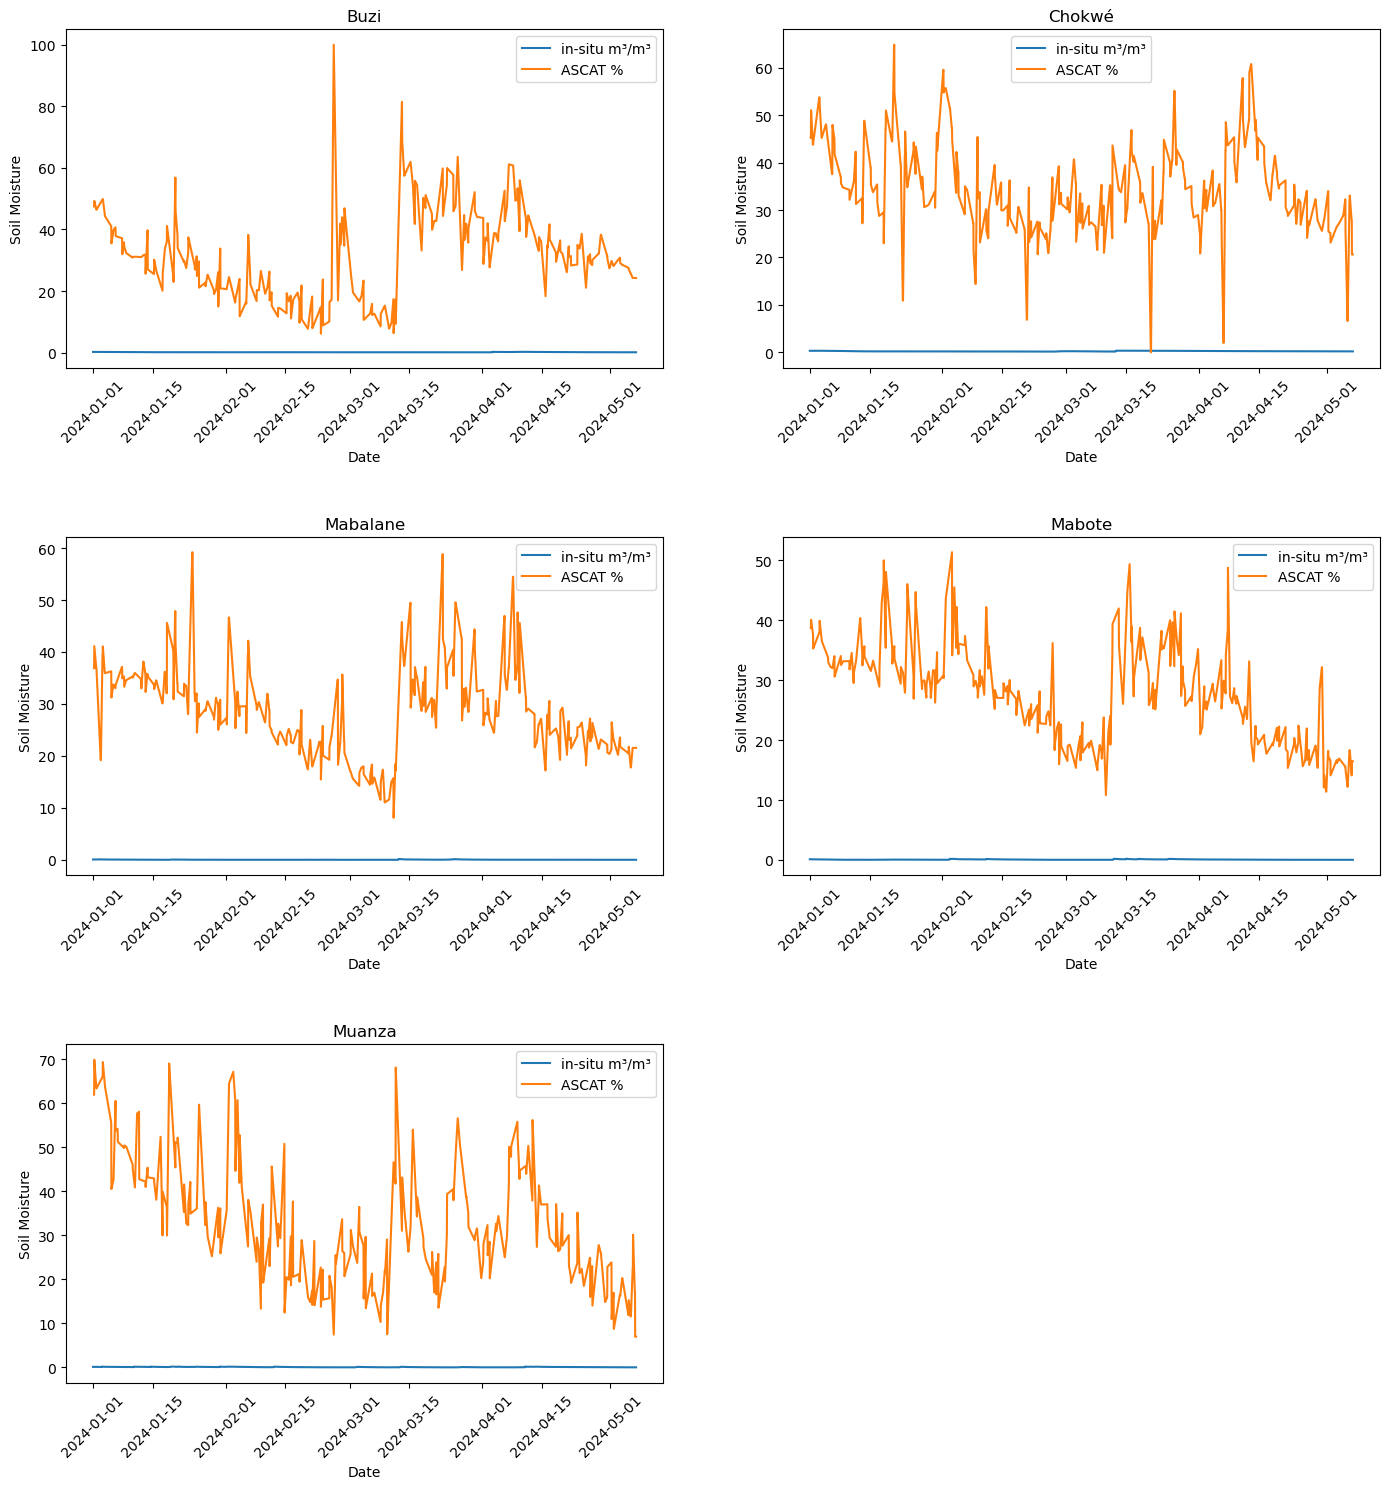

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math


# Function to plot the line graph for multiple locations in one row
def plot_multiple_locations(data, location_names, start_date, end_date):
    data['datetime'] = pd.to_datetime(data['datetime'], errors="coerce")

    num_locations = len(location_names)
    cols = 2  # Number of plots per row
    rows = math.ceil(num_locations / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), squeeze=False)

    for i, location_name in enumerate(location_names):
        row, col = divmod(i, cols)
        ax = axes[row][col]

        # Filter and process data
        location_data = data[data['location'] == location_name].copy()
        location_data = location_data[
            (location_data['datetime'] >= pd.to_datetime(start_date)) &
            (location_data['datetime'] <= pd.to_datetime(end_date))
        ]
        location_data['ascat %'] = location_data['ascat %'].bfill(limit=1)
        location_data = location_data.set_index("datetime")
        location_data['ascat interpolated'] = location_data['ascat %'].interpolate(method='time')

        # Plotting
        ax.plot(location_data.index, location_data['in-situ m³/m³'], label='in-situ m³/m³', color='tab:blue')
        ax.plot(location_data.index, location_data['ascat interpolated'], label='ASCAT %', color='tab:orange')
        ax.set_title(f'{location_name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Soil Moisture')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots if number of locations is odd
    for j in range(i + 1, rows * cols):
        row, col = divmod(j, cols)
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5) 
    plt.show()


# Example usage:
area_names =["Buzi","Chokwé","Mabalane","Mabote","Muanza"]

start_date = '2024-01-01 00:00:00'
end_date = '2024-05-07 00:00:00'
plot_multiple_locations(df, area_names, start_date, end_date)

